### 2. Data Exploration

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import random
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

data_dir = "data"

Burrito: 203 Bilder
Muffin: 3704 Bilder
Hot dog: 387 Bilder


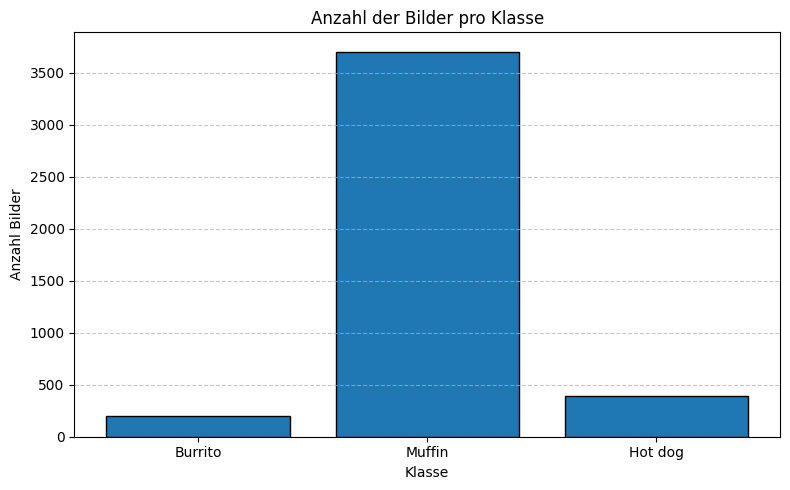

In [2]:
# Klassen & Anzahl Bilder pro Klasse
class_counts = {
    class_name: len([
        f for f in os.listdir(os.path.join(data_dir, class_name))
        if os.path.isfile(os.path.join(data_dir, class_name, f))
    ])
    for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name))
}

# Textausgabe
for cls, count in class_counts.items():
    print(f"{cls}: {count} Bilder")

# Balkendiagramm
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title("Anzahl der Bilder pro Klasse")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Unausgeglichene Klassenverteilung

Der Datensatz enthält ein starkes Ungleichgewicht zwischen den Klassen. Das Modell wird durch das Ungleichgewicht eher auf die dominante Klasse **Muffin** optimiert und vernachlässigt dabei **Hot dog** und **Burrito**.

### Mögliche Gegenmaßnahmen:
- Datenaugmentation für unterrepräsentierte Klassen
- class_weight im Training verwenden
- Confusion Matrix zur Fehlerratenanalyse

### Random Bilder

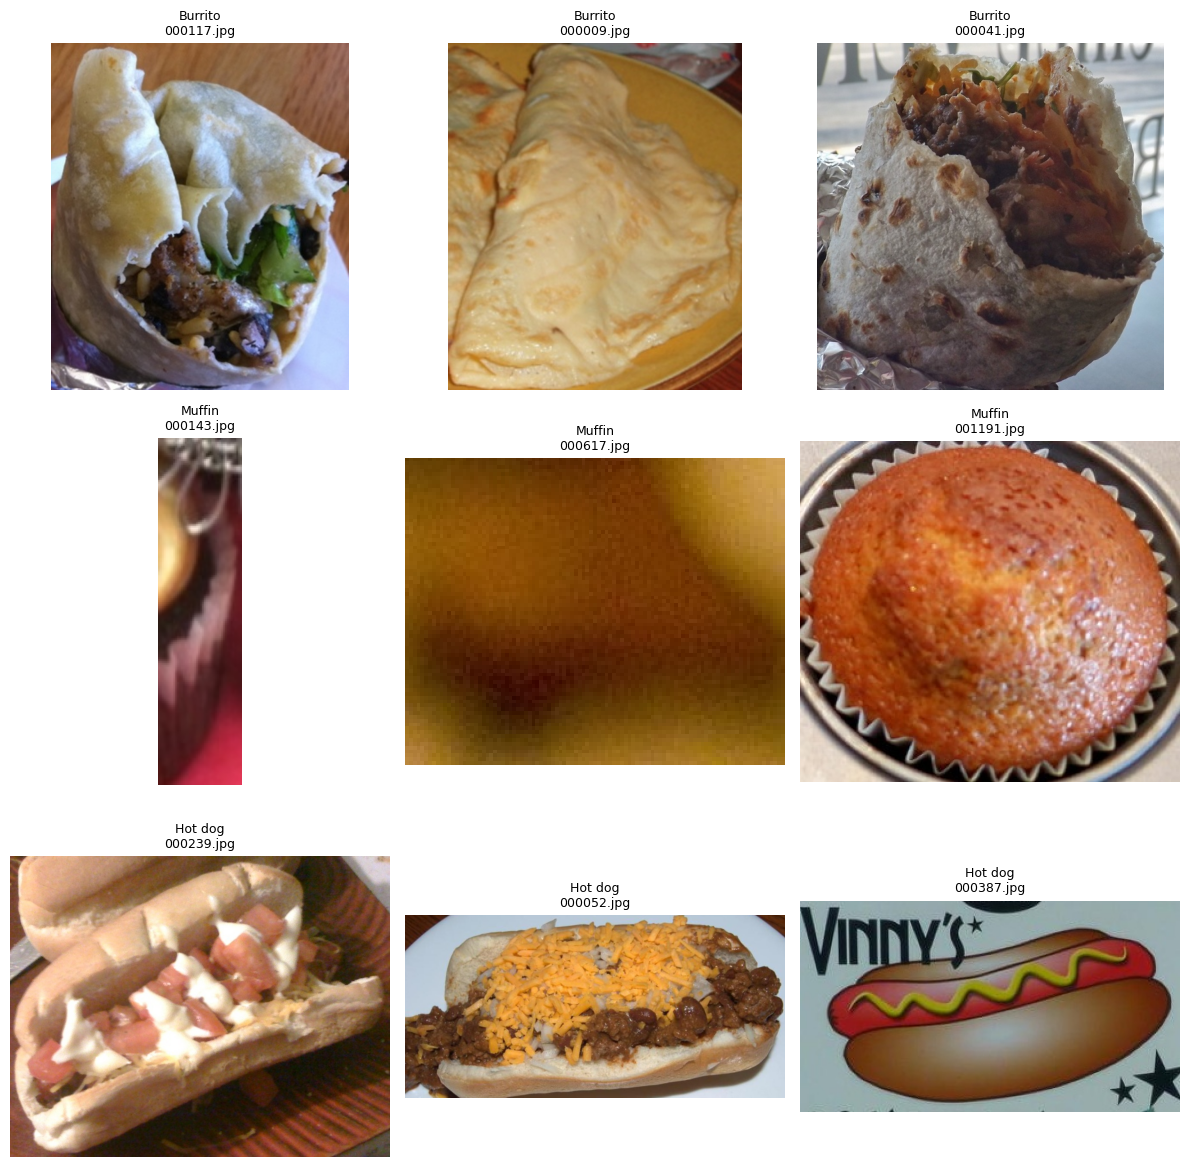

In [16]:
def show_random_images(data_dir, classes, n=3):
    plt.figure(figsize=(n * 4, len(classes) * 4))  # etwas größer für Titel
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        samples = random.sample(images, min(n, len(images)))
        for j, img_file in enumerate(samples):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            plt.subplot(len(classes), n, i * n + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{class_name}\n{img_file}", fontsize=9)
    plt.tight_layout()
    plt.show()

show_random_images(data_dir, list(class_counts.keys()), n=3)

### Mögliche Probleme beim Training

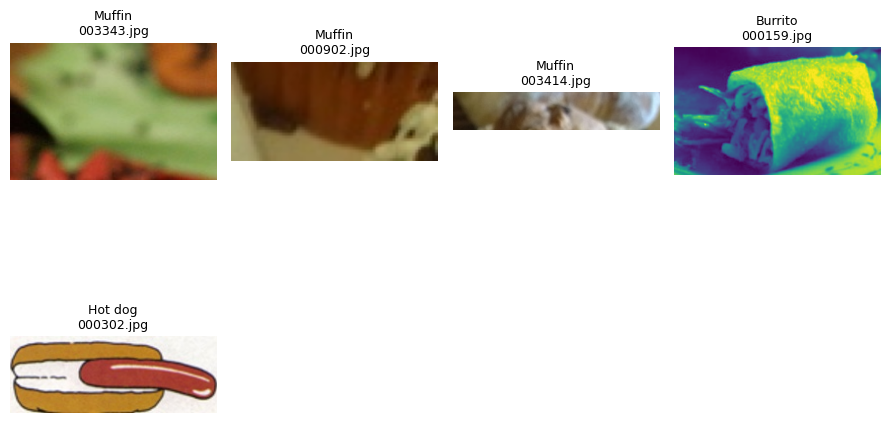

In [18]:
# Manuell ausgewählte Problem-Bilder
problem_images = {
    "Muffin": ["003343.jpg", "000902.jpg", "003414.jpg"],
    "Burrito": ["000159.jpg"],
    "Hot dog": ["000302.jpg"]
}

# Plotten
plt.figure(figsize=(len(problem_images) * 3, 6))
index = 1
for class_name, file_list in problem_images.items():
    for file_name in file_list:
        img_path = os.path.join(data_dir, class_name, file_name)
        try:
            img = Image.open(img_path)
            plt.subplot(2, 4, index)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{class_name}\n{file_name}", fontsize=9)
            index += 1
        except FileNotFoundError:
            print(f"⚠️ Datei nicht gefunden: {img_path}")
plt.tight_layout()
plt.show()

## Analyse potenziell problematischer Bilder

Die folgenden Bilder könnten das Training des Modells erschweren:

- **Unscharfe Bilder**: Z. B. `Muffin/003343.jpg` oder `Muffin dog/000902.jpg, 003414.jpg` sind stark verschwommen oder schlecht fokussiert.
- **Abweichende Farbräume**: Z. B. `Burrito/000159.jpg` hat einen untypischen blau-grünen Farbstich, der sich deutlich von anderen Trainingsbildern unterscheidet.
- **Illustrationen/Grafiken**: `Hot dog/000302.jpg` wirkt wie eine Zeichnung oder ein künstlich erstelltes Bild. Solche Inputs sind grundsätzlich nicht falsch, könnten aber zu einer schlechteren Generalisierung führen, wenn sie zu stark vom Fotostil abweichen.

### Fazit:
Diese Beispiele zeigen, dass Datenqualität eine zentrale Rolle spielt. Sie könnten später zu Fehlklassifikationen führen oder das Modell auf irrelevante Muster trainieren. Eine Option wäre, solche Ausreißer bewusst zu entfernen oder gesondert zu analysieren.

### Bild Auflösung

In [8]:
size_counter = Counter()

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            size_counter[img.size] += 1  # (width, height)
        except:
            continue

# Top 10 häufigste Größen
print("Top Bildgrößen:")
for size, count in size_counter.most_common(10):
    print(f"{size}: {count} Bilder")

Top Bildgrößen:
(1023, 767): 15 Bilder
(1022, 1022): 9 Bilder
(1023, 682): 7 Bilder
(1022, 767): 6 Bilder
(1023, 680): 6 Bilder
(1022, 766): 5 Bilder
(767, 1023): 5 Bilder
(1023, 1023): 5 Bilder
(766, 766): 3 Bilder
(215, 211): 3 Bilder


## Bildgrößenanalyse

Die Analyse der Bildgrößen zeigt, dass die Auflösungen stark variieren. Die häufigsten Formate reichen von **(1023, 767)** bis hin zu **kleineren Größen wie (215, 211)**.

### Problem:
Diese große Varianz kann beim Training Probleme verursachen, da Modelle wie ResNet feste Eingabegrößen erwarten.

### Empfehlung:
Vor dem Training sollten alle Bilder auf eine einheitliche Größe skaliert werden, z. B. **(224, 224)** – ein Standardwert für ResNet50.
